In [2]:
# Import the librairies
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

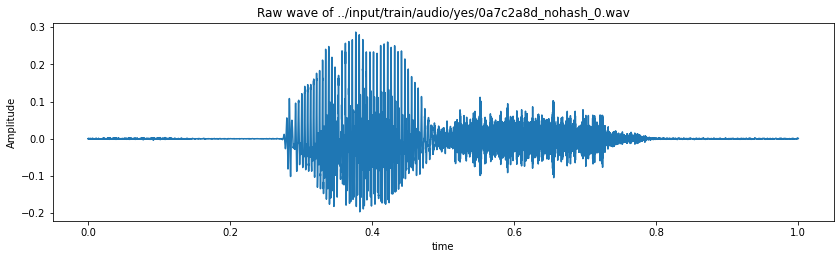

In [3]:
# Visualization of Audio signal in time series domain
train_audio_path = (r'C:\Users\S\Bureau\PROJECTS4JEDHA\FINAL_PROJECT\train\audio')
samples, sample_rate = librosa.load(train_audio_path+'/yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [4]:
#Sampling rate
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [5]:
#Resampling

#From the above, we can understand that the sampling rate of the signal is 16,000 Hz. Let us re-sample it to 8000 Hz since most of the speech-related frequencies are present at 8000 Hz:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

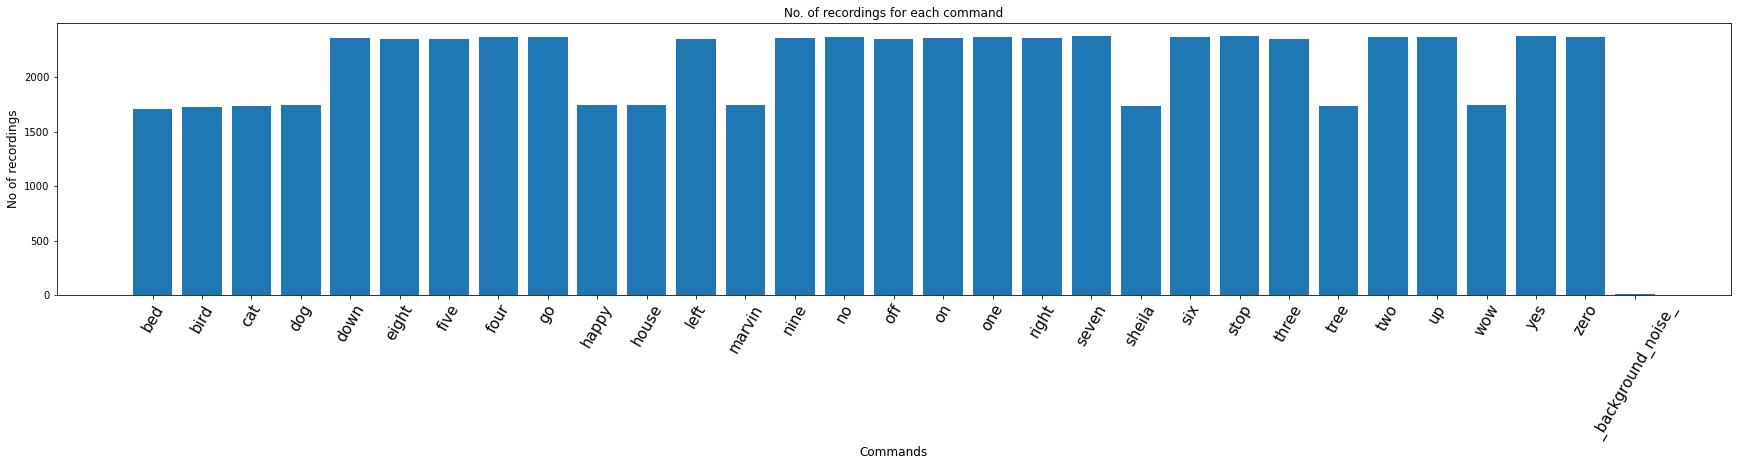

In [6]:
#Now, let’s understand the number of recordings for each voice command

labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

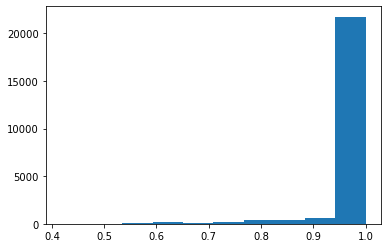

In [7]:
#Duration of recordings : A look at the distribution of the duration of recordings

duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [8]:
#Preprocessing the audio waves

#In the data exploration part earlier, we have seen that the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this.

#Here are the two steps we’ll follow:

#Resampling
#Removing shorter commands of less than 1 second
#Let us define these preprocessing steps in the below code snippet:

train_audio_path = r'C:\Users\S\Bureau\PROJECTS4JEDHA\FINAL_PROJECT\train\audio'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [9]:
#Convert the output labels to integer encoded
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [10]:
#Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [11]:
#Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [12]:
# Split into train and validation set
#We will train the model on 80% of the data and validate on the remaining 20%:

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [35]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = r"C:/Users/S/Bureau/PROJECTS4JEDHA/FINAL_PROJECT/train/cp-{epoch:04d}.ckpt" # the path where checkpoint files
# will be stored

# Create a callback that saves the model's weights every epochs
import tensorflow as tf
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True)

    
# Create a new model instance

from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [37]:
#Define the loss function to be categorical cross-entropy since it is a multi-classification problem:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

#Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[cp_callback], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - ETA: 0s - loss: 2.1575 - accuracy: 0.1856
Epoch 00001: saving model to C:/Users/S/Bureau/PROJECTS4JEDHA/FINAL_PROJECT/train\cp-0001.ckpt
533/533 [==============================] - 102s 191ms/step - loss: 2.1575 - accuracy: 0.1856 - val_loss: 1.8601 - val_accuracy: 0.3225
Epoch 2/100
533/533 [==============================] - ETA: 0s - loss: 1.5581 - accuracy: 0.4073
Epoch 00002: saving model to C:/Users/S/Bureau/PROJECTS4JEDHA/FINAL_PROJECT/train\cp-0002.ckpt
533/533 [==============================] - 102s 192ms/step - loss: 1.5581 - accuracy: 0.4073 - val_loss: 1.3092 - val_accuracy: 0.5262
Epoch 3/100
533/533 [==============================] - ETA: 0s - loss: 1.2154 - accuracy: 0.5518
Epoch 00003: saving model to C:/Users/S/Bureau/PROJECTS4JEDHA/FINAL_PROJECT/train\cp-0003.ckpt
533/533 [==============================] - 102s 191ms/step - loss: 1.2154 - accuracy: 0.5518 - val_loss: 1.1641 - val_accuracy: 0.6000
Epoch 4/100
533/533

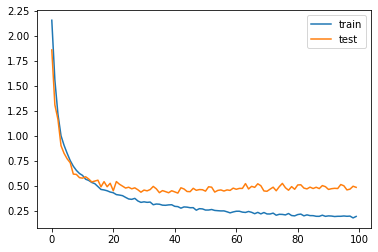

In [38]:
#Diagnostic plot

#Visualization to understand the performance of the model over a period of time:

from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [51]:
# To load a checkpoint 
model.load_weights(r'C:/Users/S/Bureau/PROJECTS4JEDHA/FINAL_PROJECT/train\cp-0099.ckpt')
model.evaluate(x_val,y_val)

134/134 [==============================] - 3s 22ms/step - loss: 0.4935 - accuracy: 0.8630


[0.4934501349925995, 0.8630072474479675]

In [52]:
model.save("model.h5")

In [54]:
from keras.models import load_model
model=load_model('model.h5')

In [55]:
#Define the function that predicts text for the given audio:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [56]:
#Prediction time! Make predictions on the validation data:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: down
Text: down


In [63]:
#Record our voices commands and test the model

import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [69]:
#Let us now read the saved voice command and convert it to text:


os.listdir(r'C:\Users\S\Final Project')
filepath=r'C:\Users\S\Final Project\yes.wav'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\S\\Final Project\\yes.wav/stop.wav'